# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [2]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
2239,53824681,"Junior Chef Glasfryn, Mold",We're looking for an ambitious Junior Chef who...,"Sychdyn (Soughton), Sir y Fflint",UK,NaN,permanent,Brunning & Price,Travel Jobs,6.50 per hour,12480,leisurejobs.com,9.431963
188779,71699681,Temporary Operations Administrator Global Chem...,Temporary Operations Administrator / Assistant...,Widnes,Widnes,NaN,contract,RecruitmentRevolution.com,Admin Jobs,19500,19500,careerbuilder.com,9.878221
137594,70413341,Up/Downstream Consultant UK,This is an exciting prospect for up and downst...,"London, UK",London,NaN,NaN,NaN,"Energy, Oil & Gas Jobs",30000 - 65000 per annum,47500,oilandgasjobsearch.com,10.768506


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [3]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [4]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [5]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [6]:
data

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
0,12612628,engineering systems analyst,engineering systems analyst dorking surrey sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk,10.126671
1,12612830,stress engineer glasgow,stress engineer glasgow salary **** to **** we...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk,10.308986
2,12612844,modelling and simulation analyst,mathematical modeller / simulation analyst / o...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk,10.308986
3,12613049,engineering systems analyst / mathematical mod...,engineering systems analyst / mathematical mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk,10.221977
4,12613647,"pioneer , miser engineering systems analyst","pioneer , miser engineering systems analyst do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk,10.126671
...,...,...,...,...,...,...,...,...,...,...,...,...,...
244763,72705211,teacher of science,position : qualified teacher subject / special...,Swindon,Swindon,NaN,contract,NaN,Teaching Jobs,450 - 500 per week,22800,hays.co.uk,10.034559
244764,72705212,teacher of business studies and ict,position : qualified teacher or nqt subject / ...,Swindon,Swindon,NaN,contract,NaN,Teaching Jobs,450 - 500 per week,22800,hays.co.uk,10.034559
244765,72705213,english teacher,position : qualified teacher subject / special...,Swindon,Swindon,NaN,contract,NaN,Teaching Jobs,450 - 500 per week,22800,hays.co.uk,10.034559
244766,72705216,supply teachers,position : qualified teacher subject / special...,Wiltshire,Wiltshire,NaN,contract,NaN,Teaching Jobs,450 to 500 per week,22800,hays.co.uk,10.034559


In [7]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
for row in data.iloc():
    token_counts.update(row['Title'].split(' '))
    token_counts.update(row['FullDescription'].split(' '))

In [8]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

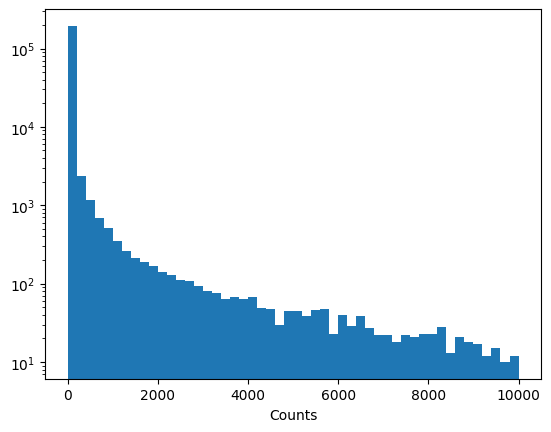

In [9]:
# Let's see how many words are there for each count

_=plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [10]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = list(map(lambda item: item[0], filter(lambda item: item[1] >= min_count, token_counts.items())))

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [11]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [12]:
token_to_id = {tokens[i]: i for i in range(len(tokens))}

In [13]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [14]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [15]:
#### print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[    2     3     4     1     1]
 [  550  2380     1     1     1]
 [  320 10714   392   307    32]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [16]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [17]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [18]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [19]:
generate_batch(data_train, 3, max_len=10)

{'Title': array([[ 7416, 34046,     0,   401,     1,     1,     1,     1,     1,
             1],
        [ 1933,   901,     1,     1,     1,     1,     1,     1,     1,
             1],
        [ 1426,   819,    53,  1010,   998, 27665,   863,    44,   325,
           819]], dtype=int32),
 'FullDescription': array([[19610, 20114,    17,   158,    14,  2117,    56,    44,   449,
           185],
        [ 1933,   901,   421,   129, 33438,   272,   129,  3675,  1613,
           129],
        [   53,  1010,   998,    72,   827,   850,   828,   177,    34,
             8]], dtype=int32),
 'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'Log1pSalary': array([11.350418, 10.042206, 10.126671], dtype=float32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [20]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [21]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()     
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.pool1(h)
        h = F.relu(h)
        h = self.dense(h)
        
        return h

In [22]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [23]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DescriptionsEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for descriptions.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()     
        self.dense = nn.Linear(out_size, out_size)

    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h = self.conv1(h)
        h = self.pool1(h)
        h = F.relu(h)
        h = self.dense(h)
        
        return h

In [24]:
desc_encoder = DescriptionsEncoder()

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


__ Task 2.2__ Build one network ~~to rule them all~~

In [25]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionsEncoder(out_size=64) 
        
        # define layers for categorical features. A few dense layers would do.
        self.dense1 = nn.Linear(n_cat_features, 128)
        self.dense2 = nn.Linear(128, 64)
        
        # define "output" layers that process depend the three encoded vectors into answer
        self.dense3 = nn.Linear(192, 96)
        self.dense4 = nn.Linear(96, 1)
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.dense1(cat_features)
        cat_h = F.relu(cat_h)
        cat_h = self.dense2(cat_h)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        h = self.dense3(joint_h)
        h = F.relu(h)
        h = self.dense4(h)
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return h[:, 0]

In [26]:
model = FullNetwork()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [27]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = Variable(torch.LongTensor(batch["Title"]))
desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
reference = Variable(torch.FloatTensor(batch[target_column]))

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [28]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference - 1) - torch.exp(prediction - 1)).mean()

In [29]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [35]:
from tqdm.notebook import trange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = trange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [31]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 100

In [36]:
for epoch_i in range(num_epochs):
    
    print(f"Training {epoch_i}:")
    train_loss = train_mae = train_batches = 0    
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):

        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.data.numpy()
        train_mae += compute_mae(reference, prediction).data.numpy()
        train_batches += 1
    
    print("\tLoss:\t%.5f" % (train_loss / train_batches))
    print("\tMAE:\t%.5f" % (train_mae / train_batches))
    print('\n\n')
    
    print(f"Validation {epoch_i}:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    with torch.no_grad():
        for batch in iterate_minibatches(data_val, shuffle=False):
            title_ix = Variable(torch.LongTensor(batch["Title"]))
            desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
            cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
            reference = Variable(torch.FloatTensor(batch[target_column]))

            prediction = model(title_ix, desc_ix, cat_features)
            loss = compute_loss(reference, prediction)

            val_loss += loss.data.numpy()
            val_mae += compute_mae(reference, prediction).data.numpy()
            val_batches += 1

    print("\tLoss:\t%.5f" % (val_loss / val_batches))
    print("\tMAE:\t%.5f" % (val_mae / val_batches))
    print('\n\n')

Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08584
	MAE:	2803.98357



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07857
	MAE:	2673.39758



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07975
	MAE:	2709.64007



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08363
	MAE:	2718.24485



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07776
	MAE:	2732.79989



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.12704
	MAE:	3892.60945



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07981
	MAE:	2679.56339



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07680
	MAE:	2657.84011



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08550
	MAE:	2893.36178



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07993
	MAE:	2672.67066



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07725
	MAE:	2708.41393



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.13531
	MAE:	4079.74297



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07468
	MAE:	2581.97270



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10327
	MAE:	2992.26531



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08372
	MAE:	2829.55694



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07977
	MAE:	2672.48435



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07705
	MAE:	2690.59709



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07915
	MAE:	2646.83709



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07720
	MAE:	2563.03334



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09909
	MAE:	3197.17733



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07854
	MAE:	2692.17806



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07889
	MAE:	2660.10721



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08500
	MAE:	2764.70585



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07807
	MAE:	2684.53815



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08056
	MAE:	2756.81238



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07796
	MAE:	2674.71231



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07628
	MAE:	2613.57558



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09010
	MAE:	2810.71517



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08139
	MAE:	2799.73064



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07796
	MAE:	2731.47129



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07648
	MAE:	2717.29409



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07531
	MAE:	2622.10515



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07479
	MAE:	2575.33285



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09083
	MAE:	2838.51778



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08081
	MAE:	2754.06202



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07956
	MAE:	2662.84463



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06992
	MAE:	2523.80490



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08146
	MAE:	2678.77803



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08135
	MAE:	2713.75857



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07696
	MAE:	2620.47010



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06788
	MAE:	2525.94568



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08872
	MAE:	2986.60848



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07687
	MAE:	2737.74470



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07562
	MAE:	2596.32022



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07691
	MAE:	2659.87697



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07513
	MAE:	2609.10498



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08273
	MAE:	2722.57930



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08123
	MAE:	2669.56337



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06960
	MAE:	2569.34673



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09138
	MAE:	2845.86259



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07728
	MAE:	2710.25833



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07563
	MAE:	2593.75068



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06585
	MAE:	2487.24465



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07809
	MAE:	2742.21334



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06633
	MAE:	2466.83339



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07366
	MAE:	2559.73925



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06899
	MAE:	2516.65459



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10045
	MAE:	3315.29990



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07606
	MAE:	2575.66970



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07921
	MAE:	2756.10189



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07599
	MAE:	2658.22211



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07362
	MAE:	2580.58389



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07595
	MAE:	2726.73807



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08202
	MAE:	2685.36719



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07816
	MAE:	2700.39600



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07501
	MAE:	2574.13888



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07177
	MAE:	2544.02163



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07379
	MAE:	2559.56849



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07537
	MAE:	2696.61300



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07384
	MAE:	2553.81225



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06159
	MAE:	2422.63193



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07398
	MAE:	2608.32331



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06304
	MAE:	2417.66706



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07666
	MAE:	2695.67355



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07202
	MAE:	2518.37820



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07349
	MAE:	2594.18744



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06866
	MAE:	2548.54511



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08541
	MAE:	2726.15555



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07154
	MAE:	2572.81963



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07929
	MAE:	2759.75422



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07335
	MAE:	2546.70360



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07430
	MAE:	2564.74338



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07374
	MAE:	2596.51030



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07515
	MAE:	2633.75922



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07574
	MAE:	2524.66261



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09700
	MAE:	2939.80041



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.08567
	MAE:	2765.04441



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07853
	MAE:	2736.22236



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06780
	MAE:	2478.07236



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07333
	MAE:	2604.83563



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06885
	MAE:	2495.91455



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07449
	MAE:	2634.52050



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07674
	MAE:	2592.07631



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07848
	MAE:	2740.93738



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07771
	MAE:	2702.44264



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08655
	MAE:	2756.34819



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07755
	MAE:	2690.59634



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08863
	MAE:	2980.69503



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07572
	MAE:	2666.94677



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07368
	MAE:	2550.86860



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07268
	MAE:	2606.14017



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09396
	MAE:	3107.81814



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06964
	MAE:	2484.71215



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09166
	MAE:	3079.79258



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07066
	MAE:	2518.74715



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07365
	MAE:	2552.95317



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06784
	MAE:	2460.43533



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09978
	MAE:	3282.90923



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06655
	MAE:	2477.85751



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09681
	MAE:	2896.77761



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06813
	MAE:	2524.72292



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08561
	MAE:	2740.34171



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06506
	MAE:	2398.97141



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10401
	MAE:	3068.13181



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06683
	MAE:	2416.44866



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09123
	MAE:	2843.46622



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07149
	MAE:	2665.19150



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07524
	MAE:	2569.53961



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06790
	MAE:	2468.80338



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.06992
	MAE:	2512.61736



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06197
	MAE:	2388.39446



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07490
	MAE:	2564.62734



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06332
	MAE:	2387.43089



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07132
	MAE:	2540.54850



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06476
	MAE:	2451.05653



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08672
	MAE:	2997.79108



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07061
	MAE:	2539.59174



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07275
	MAE:	2513.08152



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06661
	MAE:	2465.66968



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07036
	MAE:	2542.30436



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06932
	MAE:	2492.70474



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.06970
	MAE:	2499.62088



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06461
	MAE:	2439.04694



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07044
	MAE:	2556.42298



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06618
	MAE:	2475.07729



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08205
	MAE:	2673.18511



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06574
	MAE:	2425.57055



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07729
	MAE:	2607.37915



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07226
	MAE:	2612.10694



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07043
	MAE:	2492.99897



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06654
	MAE:	2500.65605



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08281
	MAE:	2696.28585



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06364
	MAE:	2466.48280



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07532
	MAE:	2548.54347



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.07447
	MAE:	2557.53161



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09656
	MAE:	2911.80120



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06527
	MAE:	2512.77164



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07175
	MAE:	2516.02797



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06811
	MAE:	2507.42415



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07164
	MAE:	2542.98989



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06412
	MAE:	2440.19111



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08011
	MAE:	2677.10034



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06688
	MAE:	2486.05652



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.06990
	MAE:	2504.27528



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06423
	MAE:	2494.19187



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09515
	MAE:	3170.07838



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06524
	MAE:	2521.56668



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08416
	MAE:	2731.88891



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06088
	MAE:	2392.92452



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.06958
	MAE:	2478.64415



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06115
	MAE:	2374.53666



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.06881
	MAE:	2463.99291



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06409
	MAE:	2419.13323



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09827
	MAE:	2932.57264



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06139
	MAE:	2452.80050



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07353
	MAE:	2631.87424



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.05630
	MAE:	2302.00807



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07358
	MAE:	2533.72969



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06670
	MAE:	2495.10991



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07509
	MAE:	2681.14788



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06795
	MAE:	2433.42117



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08856
	MAE:	3021.87481



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06616
	MAE:	2494.37964



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07002
	MAE:	2473.33064



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.05983
	MAE:	2362.30996



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07118
	MAE:	2552.16508



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06456
	MAE:	2529.69910



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.09838
	MAE:	3324.23915



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06271
	MAE:	2402.55658



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07579
	MAE:	2553.02616



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06071
	MAE:	2328.73841



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08116
	MAE:	2821.44034



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06682
	MAE:	2474.64912



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.06905
	MAE:	2491.43400



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.05522
	MAE:	2222.35396



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08540
	MAE:	2934.78736



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06505
	MAE:	2371.13180



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.08749
	MAE:	2753.71682



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06664
	MAE:	2412.05996



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.06879
	MAE:	2500.92275



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.05717
	MAE:	2336.83042



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07022
	MAE:	2472.47507



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06518
	MAE:	2444.38451



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07828
	MAE:	2787.43407



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06378
	MAE:	2428.40899



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.10586
	MAE:	3045.28775



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06148
	MAE:	2382.12099



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.07601
	MAE:	2564.34088



Training:


  0%|          | 0/100 [00:00<?, ?it/s]

	Loss:	0.06500
	MAE:	2406.15978



Validation:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.06762
	MAE:	2479.18025





In [37]:
print("Final eval:")
val_loss = val_mae = val_batches = 0

with torch.no_grad():
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = Variable(torch.LongTensor(batch["Title"]))
        desc_ix = Variable(torch.LongTensor(batch["FullDescription"]))
        cat_features = Variable(torch.FloatTensor(batch["Categorical"]))
        reference = Variable(torch.FloatTensor(batch[target_column]))

        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.data.numpy()
        val_mae += compute_mae(reference, prediction).data.numpy()
        val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

Final eval:


  0%|          | 0/765 [00:00<?, ?it/s]

	Loss:	0.06762
	MAE:	2479.18025





### Task 3.2: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

Please tell us what you did and how did it work.

`<YOUR_TEXT_HERE>`, i guess...